#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import json
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from collections import Counter
from tqdm.notebook import tqdm

In [4]:
from params import *

In [5]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidInfDataset
from data.transforms import get_tranfos_inference

from model_zoo.models import get_model

from utils.logger import Config

from utils.metrics import study_level_map

## Data

## Dataset

In [6]:
root = DATA_PATH + f"train_{SIZE}/"

In [7]:
df = prepare_dataframe().copy()

In [8]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [9]:
df = add_additional_boxes(df)

In [10]:
transforms = get_tranfos_inference()
dataset = CovidInfDataset(df, root, transforms=transforms)

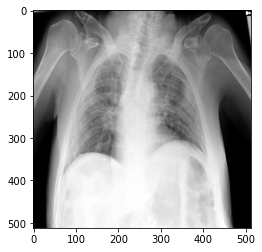

In [11]:
img = dataset[0]
plt.imshow((img.numpy().transpose(1, 2, 0) + 1) / 2)
plt.show()

In [12]:
img.shape

torch.Size([3, 512, 512])

# Main

In [13]:
from inference.predict import predict
from utils.torch import load_model_weights
from utils.metrics import study_level_map
from sklearn.metrics import roc_auc_score

def inference_val(
    config,
    log_folder,
    df,
    root_dir="",
    flip_tta=False,
    scale_tta=False,
):
    """
    Inference on the test data.
    Args:
        config (Config): Parameters.
        weights (list of strings): Model weights.
        log_folder (None or str, optional): Folder to load the weights from. Defaults to None.
        flip_tta (bool, optional): Whether to use hflip tta. Defaults to False.
        scale_tta (bool, optional): Whether to use scale tta. Defaults to False.
    """

    model = get_model(
        config.selected_model,
        use_unet=config.use_unet,
        num_classes=config.num_classes,
    ).to(config.device)
    model.zero_grad()
    
    weights = sorted(glob.glob(EXP_FOLDER + "*.pt"))
    assert len(weights) == config.k
    
    pred_oof_study = np.zeros((len(df), config.num_classes))
    pred_oof_img = np.zeros(len(df))
    for i, weight in enumerate(weights):
        load_model_weights(model, weight)
        
        df_val = df[df[config.folds_col] == i].copy().reset_index(drop=True)
        dataset = CovidInfDataset(
            df_val,
            root_dir=root_dir,
            transforms=get_tranfos_inference(mean=model.mean, std=model.std),
        )

        pred_study, pred_img = predict(
            model,
            dataset,
            batch_size=config.val_bs,
            num_classes=config.num_classes,
            flip_tta=flip_tta,
            scale_tta=scale_tta,
            device=config.device,
        )
        
        val_idx = np.array(df[df[config.folds_col] == i].index)
        pred_oof_study[val_idx] = pred_study
        pred_oof_img[val_idx] = pred_img

    if log_folder is not None:
        suffix = "_flip" * flip_tta + "_scale" * scale_tta
        np.save(log_folder + 'pred_oof_study' + suffix + '.npy', pred_oof_study)
        np.save(log_folder + 'pred_oof_img' + suffix + '.npy', pred_oof_img)
        
    score_study = study_level_map(
        pred_oof_study, df[CLASSES].values, df["study_id"]
    )
    score_img = roc_auc_score(df["img_target"].values, pred_oof_img)

    print('CV Scores :')
    print(f' -> Study mAP : {score_study :.4f}')
    print(f' -> Image AUC : {score_img :.4f}')

    return pred_oof_study, pred_oof_img

In [15]:
# EXP_FOLDER = LOG_PATH + "2021-07-30/4/"
# EXP_FOLDER = LOG_PATH + "2021-07-31/0/"
EXP_FOLDER = LOG_PATH + "2021-08-01/1/"

config = Config(json.load(open(EXP_FOLDER + "config.json", 'r')))
weights = sorted(glob.glob(EXP_FOLDER + "*.pt"))

In [16]:
pred_oof_study, pred_oof_img = inference_val(
    config,
    EXP_FOLDER,
    df,
    root_dir=root,
    flip_tta=True,
    scale_tta=False,
)


 -> Loading weights from ../logs/2021-08-01/1/tf_efficientnetv2_l_in21ft1k_model_0.pt


 -> Loading weights from ../logs/2021-08-01/1/tf_efficientnetv2_l_in21ft1k_model_1.pt


 -> Loading weights from ../logs/2021-08-01/1/tf_efficientnetv2_l_in21ft1k_model_2.pt


 -> Loading weights from ../logs/2021-08-01/1/tf_efficientnetv2_l_in21ft1k_model_3.pt


 -> Loading weights from ../logs/2021-08-01/1/tf_efficientnetv2_l_in21ft1k_model_4.pt

CV Scores :
 -> Study mAP : 0.3734
 -> Image AUC : 0.9067
